---
# Source2Suffering Notebook
---

**Author** : Amaury Laridon

**Date** : 10/06/2025

**Content** : Notebook used for development of the pipelines needed for the Laridon et al.(2025) publication. 

---

Init Libraries and Path

In [63]:
#%%  ----------------------------------------------------------------
# import and path
# ----------------------------------------------------------------

import xarray as xr
import pickle as pk
import time
# from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib as mpl
import mapclassify as mc
from copy import deepcopy as cp
import os
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import cartopy.crs as ccrs
import cartopy as cr
import geopandas as gpd
import sys
from operator import index
import numpy as np
import pandas as pd
from scipy import interpolate
from scipy import stats as sts
import regionmask as rm
import glob
%matplotlib inline

notebook_path = os.getcwd()  # Current path
print("Directory of the notebook:", notebook_path)
notebook_path = notebook_path

scripts_dir = "/data/brussel/vo/000/bvo00012/vsc11137/source2suffering"
data_dir = scripts_dir+"/data/"

sys.path.append(os.path.abspath(scripts_dir))

Directory of the notebook: /vscmnt/brussel_pixiu_data/_data_brussel/vo/000/bvo00012/vsc11137/source2suffering/notebooks


Settings

In [64]:
ages = np.arange(60,-1,-1)
age_young = 0
age_ref = np.nanmax(ages)
age_range = np.arange(0,105)
year_ref = 2020
year_start = year_ref - age_ref
birth_years = np.arange(year_start,year_ref+1)     
year_end = 2113 # based on maximum life expectancy reported in UNWPP
year_range = np.arange(year_start,year_end+1)
# Definition of the hazards 
hazards = [
    "burntarea",
    "cropfailedarea",
    "driedarea",
    "floodedarea",
    "heatwavedarea",
    "tropicalcyclonedarea"
]
hazards_name = [
    "Wildfires",
    "Crop Failures",
    "Droughts",
    "River Floods",
    "Heatwaves",
    "Tropical Cyclones"
]

## 1. Reference Pulse of 1 GtCO2eq

In [65]:
# Load the values computed by the Source2Suffering framework with the new demography #
with open(data_dir+'{}/source2suffering/reference_pulse/ds_S2S_Reference_Pulse_gmt_{}_{}.pkl'.format('pickles_S2S_v1','ar6_new','rm'), 'rb') as f:
        ds_S2S_Reference_Pulse_gmt_ar6_new_rm = pk.load(f)

print(ds_S2S_Reference_Pulse_gmt_ar6_new_rm)

<xarray.Dataset>
Dimensions:                                                         (hazard: 6,
                                                                     birth_year: 22)
Coordinates:
  * hazard                                                          (hazard) <U20 ...
  * birth_year                                                      (birth_year) int64 ...
Data variables:
    valc_nr_children_facing_extra_hazard_Reference_Pulse            (hazard, birth_year) float64 ...
    valc_total_nr_children_facing_extra_hazard_Reference_Pulse      (hazard) float64 ...
    valc_slope_exposure                                             (hazard, birth_year) float64 ...
    valc_nr_children_facing_extra_hazard_Reference_Pulse_ref        (hazard, birth_year) float64 ...
    valc_total_nr_children_facing_extra_hazard_Reference_Pulse_ref  (hazard) float64 ...
    valc_slope_exposure_ref                                         (hazard, birth_year) float64 ...


### 1.1 Total number of the people exposed to an additional hazard

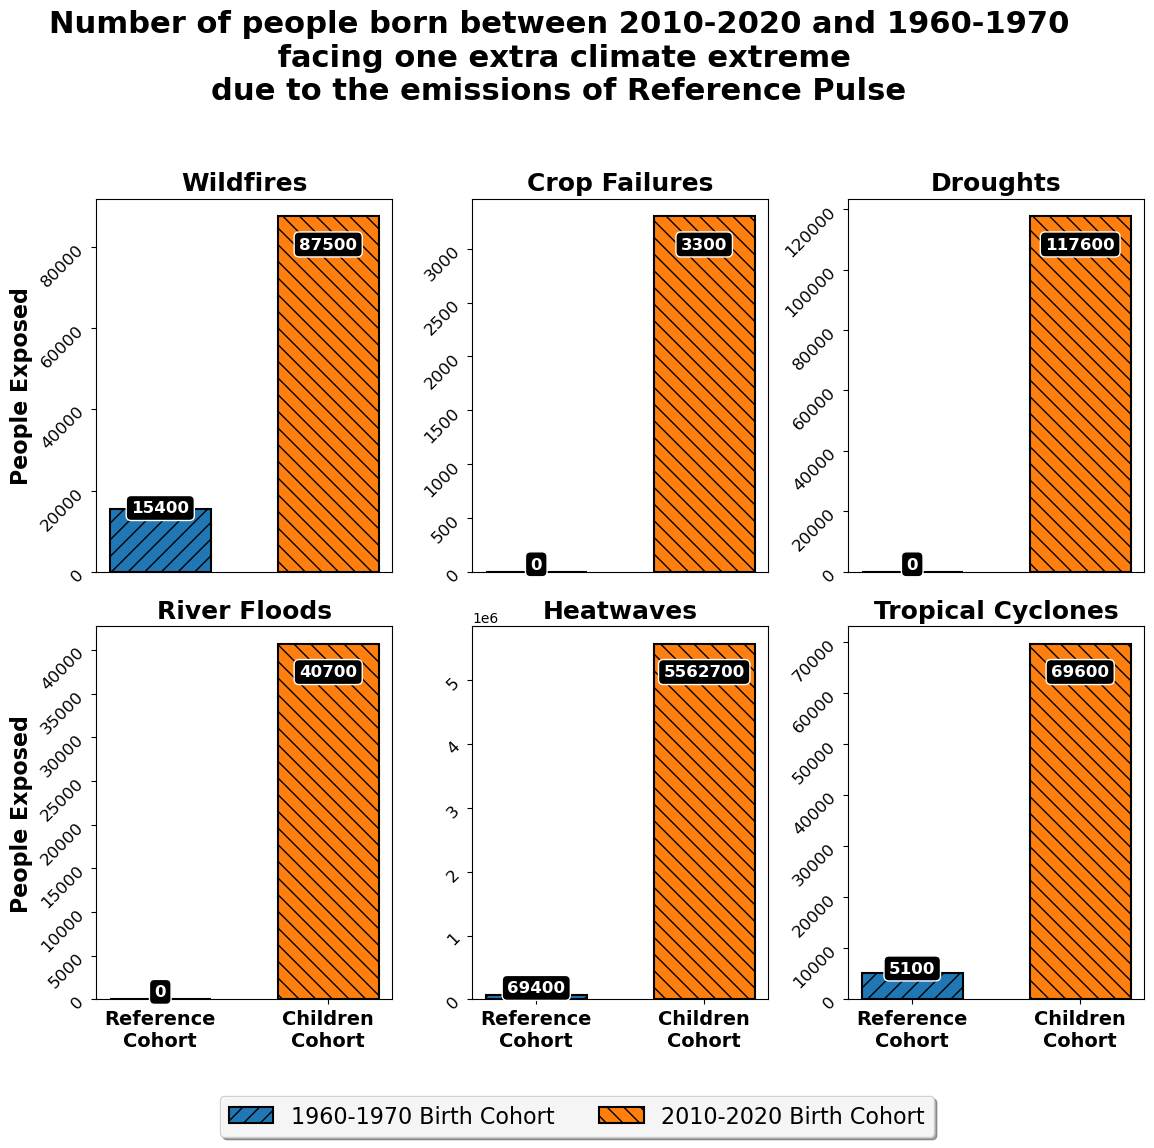

In [66]:
plt.close('all')

# Get data from the dataset
hazards = ds_S2S_Reference_Pulse_gmt_ar6_new_rm[
    'valc_total_nr_children_facing_extra_hazard_Reference_Pulse'
].coords['hazard'].values

values_s2s_ref = ds_S2S_Reference_Pulse_gmt_ar6_new_rm[
    'valc_total_nr_children_facing_extra_hazard_Reference_Pulse_ref'
].values

values_s2s = ds_S2S_Reference_Pulse_gmt_ar6_new_rm[
    'valc_total_nr_children_facing_extra_hazard_Reference_Pulse'
].values

n = len(hazards)

order_indices = [np.where(hazards == h)[0][0] for h in hazards]
values_s2s_ref = values_s2s_ref[order_indices]
values_s2s = values_s2s[order_indices]
#hazards = np.array(hazards)

fig, axs = plt.subplots(2, 3, figsize=(12, 12), sharey=False)

axs = axs.flatten()

for i in range(n):
    ax = axs[i]

    bar_ref = ax.bar(0, values_s2s_ref[i], width=0.6, color='tab:blue', hatch='//',
                     label='1960-1970 Birth Cohort', edgecolor='black', linewidth=1.5)
    bar_s2s = ax.bar(1, values_s2s[i], width=0.6, color='tab:orange', hatch='\\\\',
                     label='2010-2020 Birth Cohort', edgecolor='black', linewidth=1.5)

    ax.set_title(hazards_name[i], fontsize=18, fontweight='bold')

    if i % 3 == 0:
        ax.set_ylabel('People Exposed', fontsize=16, fontweight='bold')

    if i // 3 == 1:
        ax.set_xticks([0, 1])
        ax.set_xticklabels(['Reference\nCohort', 'Children\nCohort'], fontsize=14, fontweight='bold')
    else:
        ax.set_xticks([])

    ax.tick_params(axis='y', labelsize=12, rotation=45)

    if not np.isnan(values_s2s_ref[i]):
        ax.text(0, values_s2s_ref[i] * 0.90, f'{int(np.round(values_s2s_ref[i]))}',
                ha='center', va='bottom', fontsize=12, fontweight='bold', color='white',
                bbox=dict(facecolor='black', edgecolor='white', boxstyle='round,pad=0.3'))
    if not np.isnan(values_s2s[i]):
        ax.text(1, values_s2s[i] * 0.90, f'{int(np.round(values_s2s[i]))}',
                ha='center', va='bottom', fontsize=12, fontweight='bold', color='white',
                bbox=dict(facecolor='black', edgecolor='white', boxstyle='round,pad=0.3'))

fig.suptitle(
    "Number of people born between 2010-2020 and 1960-1970\n facing one extra climate extreme\n"
    "due to the emissions of Reference Pulse",
    fontsize=22, fontweight='bold', y=0.95
)

handles, labels = axs[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', ncol=2, fontsize=16, frameon=True, framealpha=0.9, fancybox=True, shadow=True)

plt.tight_layout(rect=[0.03, 0.07, 1, 0.92])
plt.savefig(scripts_dir + '/figures/source2suffering/reference_pulse/fig1_Reference_Pulse_valc_total.png',bbox_inches='tight',dpi=300)
plt.show()


## 2. Spatialization of the exposure

### 2.1 Spatialization at the regional level

In [67]:
# Load the values computed by the Source2Suffering framework with the new demography #
with open(data_dir+'{}/source2suffering/reference_pulse/ds_S2S_Reference_Pulse_Regions_gmt_{}_{}.pkl'.format('pickles_S2S_v1','ar6_new','rm'), 'rb') as f:
        ds_S2S_Reference_Pulse_Regions_gmt_ar6_new_rm = pk.load(f)

print(ds_S2S_Reference_Pulse_Regions_gmt_ar6_new_rm)

<xarray.Dataset>
Dimensions:                                                         (hazard: 6,
                                                                     birth_year: 22,
                                                                     region: 8)
Coordinates:
  * hazard                                                          (hazard) <U20 ...
  * birth_year                                                      (birth_year) int64 ...
  * region                                                          (region) object ...
Data variables:
    valc_nr_children_facing_extra_hazard_Reference_Pulse            (region, hazard, birth_year) float64 ...
    valc_nr_children_facing_extra_hazard_Reference_Pulse_ref        (region, hazard, birth_year) float64 ...
    valc_total_nr_children_facing_extra_hazard_Reference_Pulse      (region, hazard) float64 ...
    valc_total_nr_children_facing_extra_hazard_Reference_Pulse_ref  (region, hazard) float64 ...
    valc_slope_exposure         

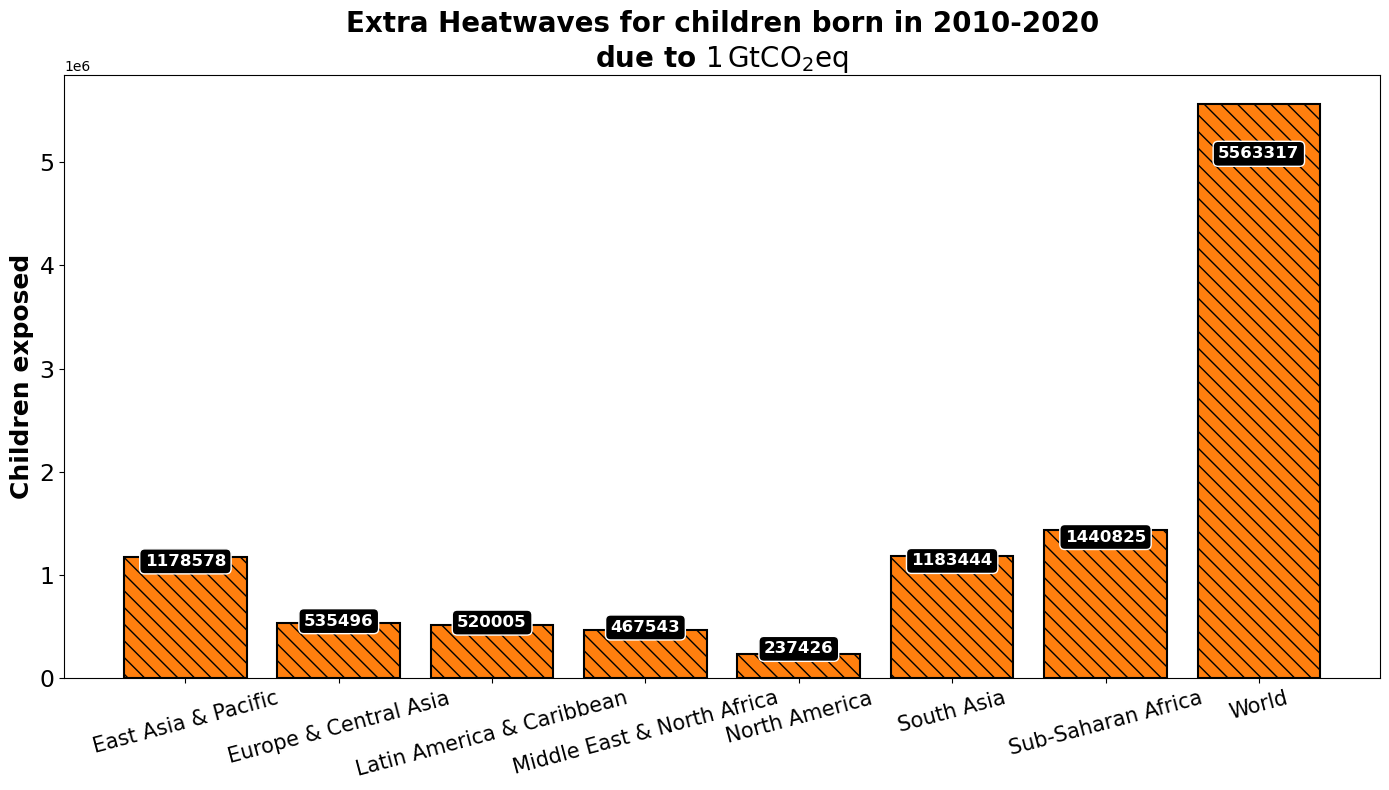

In [68]:
plt.close('all')

hazard_idx = 4  # Heat waves

hazard_name_str = hazards_name[hazard_idx]

valc_total_values = ds_S2S_Reference_Pulse_Regions_gmt_ar6_new_rm['valc_total_nr_children_facing_extra_hazard_Reference_Pulse'].sel(hazard=hazards[hazard_idx]).values
regions = ds_S2S_Reference_Pulse_Regions_gmt_ar6_new_rm.coords['region'].values

x_pos = np.arange(len(regions))

x_labels = [r.decode() if isinstance(r, bytes) else str(r) for r in regions]

fig, ax = plt.subplots(figsize=(14,8))

bars = ax.bar(x_pos, valc_total_values, color='tab:orange', hatch='\\\\', edgecolor='black', linewidth=1.5)

ax.set_xticks(x_pos)
ax.set_xticklabels(x_labels, fontsize=15, rotation=15)
ax.set_ylabel('Children exposed', fontsize=18, fontweight='bold')
ax.tick_params(axis='y', labelsize=17)

ax.set_title(f'Extra {hazard_name_str} for children born in 2010-2020\ndue to $1\,\mathrm{{GtCO}}_2\mathrm{{eq}}$', 
             fontsize=20, fontweight='bold')

for rect, value in zip(bars, valc_total_values):
    if not np.isnan(value):
        ax.text(rect.get_x() + rect.get_width() / 2, value * 0.90, f'{int(np.round(value))}',
                ha='center', va='bottom', fontsize=12, fontweight='bold', color='white',
                bbox=dict(facecolor='black', edgecolor='white', boxstyle='round,pad=0.3'))

plt.tight_layout()
plt.savefig(scripts_dir + f'/figures/source2suffering/reference_pulse/fig2_Reference_Pulse_{hazard_name_str}_regions_comp.png', bbox_inches='tight', dpi=300)
plt.show()

## 2. Monte Carlo Sampling

### 2.1 Definition of PDFs

#### 2.1.1 Definition of Standardised PDFs 

##### Normal Distribution for Emissions

Based on an arbitrary value for std_dev

In [69]:
# Load the normal distribution created for the emissions # 

with open(data_dir+'{}/source2suffering/pdf/emissions/pdf_emissions_norm_test.pkl'.format('pickles_S2S_v1'), 'rb') as f:
        pdf_emissions = pk.load(f)

print(pdf_emissions)

<bound method rv_frozen.pdf of <scipy.stats._distn_infrastructure.rv_frozen object at 0x14eda544f7c0>>


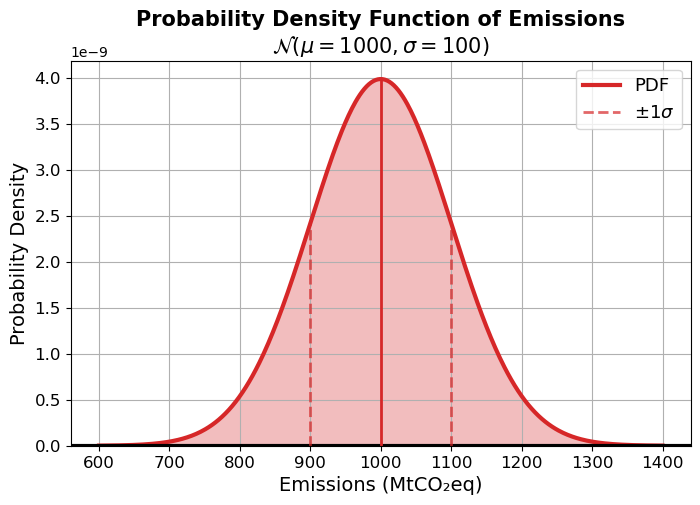

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

emissions_best_estimate = 1000e6
emissions_std_dev = 100e6

# ---------------------- Plot the PDF ---------------------- #
x = np.linspace(emissions_best_estimate - 4 * emissions_std_dev,
                emissions_best_estimate + 4 * emissions_std_dev, 500)
y = pdf_emissions(x)

x_mtco2eq = x / 1e6  # Convert to MtCO2eq for display

mu = emissions_best_estimate / 1e6
sigma = emissions_std_dev / 1e6

# Fonction pour récupérer la valeur PDF la plus proche
def get_pdf_value(x_val):
    idx = (np.abs(x_mtco2eq - x_val)).argmin()
    return y[idx]

y_mu = get_pdf_value(mu)
y_mu_minus_sigma = get_pdf_value(mu - sigma)
y_mu_plus_sigma = get_pdf_value(mu + sigma)

plt.figure(figsize=(8, 5))
plt.plot(
    x_mtco2eq,
    y,
    color='tab:red',
    label='PDF',
    lw=3
)

plt.fill_between(x_mtco2eq, y, color='tab:red', alpha=0.3)
plt.axhline(0, color='black', lw=3)

# Barres verticales partielles
plt.plot([mu, mu], [0, y_mu], color='tab:red', lw=2, linestyle='-')               # moyenne
plt.plot([mu - sigma, mu - sigma], [0, y_mu_minus_sigma], color='tab:red', lw=2, linestyle='--', alpha=0.7, label=r'$\pm 1 \sigma$')  # moyenne - 1σ
plt.plot([mu + sigma, mu + sigma], [0, y_mu_plus_sigma], color='tab:red', lw=2, linestyle='--', alpha=0.7)  # moyenne + 1σ

plt.xlabel('Emissions (MtCO₂eq)', fontsize=14)
plt.ylabel('Probability Density', fontsize=14)

plt.title(
    'Probability Density Function of Emissions\n'
    r'$\mathcal{N}(\mu=%.0f, \sigma=%.0f)$' % (mu, sigma),
    fontweight='bold',
    fontsize=15,
    loc='center'
)

# Ticks normaux, tick size augmenté
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.ylim(bottom=0)
plt.legend(fontsize=13)
plt.grid(True)

plt.savefig(scripts_dir + '/figures/source2suffering/pdf/fig1_stand_norm_pdf_emissions.png', bbox_inches='tight', dpi=300)
plt.show()


##### Normal Distribution for Emissions

Based on the assumption of a Normal distribution but use the best estimate and the std_dev from IPCC AR6

In [72]:
# Load the normal distribution created for the TCRE # 

with open(data_dir+'{}/source2suffering/pdf/tcre/pdf_tcre_norm_test.pkl'.format('pickles_S2S_v1'), 'rb') as f:
        pdf_tcre = pk.load(f)

print(pdf_tcre)

<bound method rv_frozen.pdf of <scipy.stats._distn_infrastructure.rv_frozen object at 0x14ed9c55c580>>


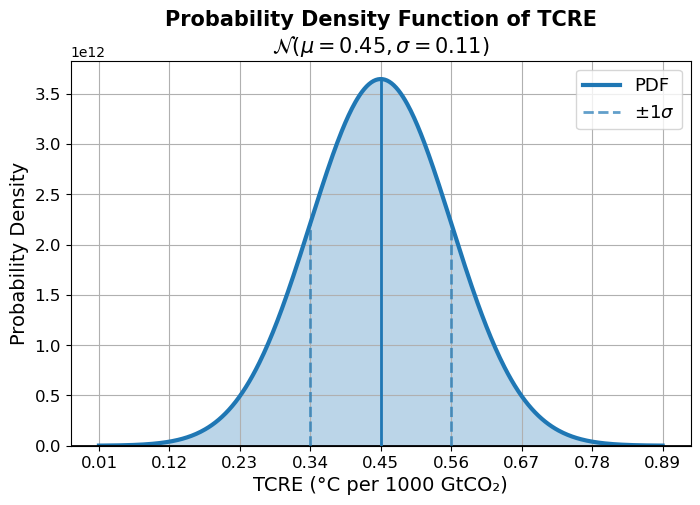

In [100]:
# Best estimate and standard deviation for TCRE (in °C per tonne CO₂)
tcre_best_estimate = 0.45 / 1e12  # °C per tonne CO₂ → correspond à 0.45 °C per 1000 GtCO₂
tcre_std_dev = 0.1094 / 1e12      # °C per tonne CO₂ → correspond à 0.1094 °C per 1000 GtCO₂

# Define the x-axis range: typically mean ± 4*std_dev
x = np.linspace(tcre_best_estimate - 4 * tcre_std_dev, tcre_best_estimate + 4 * tcre_std_dev, 500)

# Compute PDF values for these x
y = pdf_tcre(x)

# Conversion pour affichage en °C per 1000 GtCO₂
x_display = x * 1e12

# Positions moyenne et écart type en affichage
mu = 0.45
sigma = 0.1094

# Calculer les valeurs de PDF aux positions mu ± sigma
# Pour tracer la barre verticale partielle, on récupère le y correspondant à la position x verticale
def get_pdf_value(x_val):
    # Trouve l’indice dans x_display le plus proche de x_val
    idx = (np.abs(x_display - x_val)).argmin()
    return y[idx]

# Valeurs y aux positions mu et mu ± sigma
y_mu = get_pdf_value(mu)
y_mu_minus_sigma = get_pdf_value(mu - sigma)
y_mu_plus_sigma = get_pdf_value(mu + sigma)

# Plot
plt.figure(figsize=(8, 5))
plt.plot(
    x_display,
    y,
    color='tab:blue',
    label=f'PDF',
    lw=3
)

# Remplissage sous la courbe
plt.fill_between(x_display, y, color='tab:blue', alpha=0.3)

# Ligne y=0
plt.axhline(0, color='black', lw=2)

# Barres verticales partielles (depuis y=0 jusqu'à la valeur du PDF)
plt.plot([mu, mu], [0, y_mu], color='tab:blue', lw=2, linestyle='-')               # moyenne
plt.plot([mu - sigma, mu - sigma], [0, y_mu_minus_sigma], color='tab:blue', lw=2, linestyle='--', alpha=0.7, label=r'$\pm 1 \sigma$')  # moyenne - 1σ
plt.plot([mu + sigma, mu + sigma], [0, y_mu_plus_sigma], color='tab:blue', lw=2, linestyle='--', alpha=0.7)  # moyenne + 1σ

plt.xlabel('TCRE (°C per 1000 GtCO₂)', fontsize=14)
plt.ylabel('Probability Density', fontsize=14)
plt.title(
    'Probability Density Function of TCRE\n'
    r'$\mathcal{N}(\mu=%.2f, \sigma=%.2f)$' % (mu, sigma),
    fontweight='bold',
    fontsize=15,
    loc='center'
)
# Tick x centrés sur la moyenne, espacés d’un écart type
ticks = np.arange(mu - 4 * sigma, mu + 4 * sigma + 0.0001, sigma)
plt.xticks(ticks, [f"{tick:.2f}" for tick in ticks], fontsize=12)
plt.yticks(fontsize=12)
plt.ylim(bottom=-0.001)

plt.legend(fontsize=13)
plt.grid(True)
plt.savefig(scripts_dir + '/figures/source2suffering/pdf/fig1_stand_norm_pdf_tcre.png', bbox_inches='tight', dpi=300)

plt.show()


#### 2.1.2 Definition of Complex PDFs  